In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import tropical
from tropical import Tropical, TropicalMonomial, TropicalPolynomial
from tropical import to_tensor, Tropical, TropicalMonomial, TropicalPolynomial, PolyNet, DiffPolyNet

In [3]:
%matplotlib inline

In [4]:
def to_tensor(x):
    return torch.tensor(x).float()

In [5]:
t = Tropical(0)

In [6]:
a = TropicalPolynomial([[0,1,0],[0,0,1],[0,0,2]])

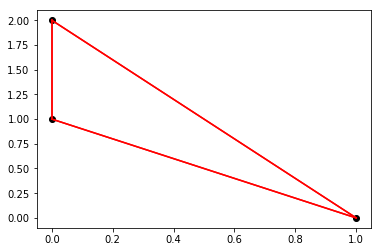

In [7]:
a.plot_dual_sub(color='red')

In [8]:
a

b^2 ⨁ a ⨁ b

In [9]:
x = [-10,-2]

In [10]:
a.evaluate(x)

-2

In [11]:
a_net = PolyNet(a)

In [12]:
a_net

PolyNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [13]:
a_net.forward(torch.tensor(x).float())

tensor([-2.], grad_fn=<AddBackward0>)

In [14]:
def convert_net_to_tropical(model):
    
    d = model.net[0].in_features
    f = [TropicalPolynomial([[0]+np.eye(d)[i].tolist()]) for i in range(d)]
    
    g = [TropicalPolynomial([[0]+np.zeros(d).tolist()]) for i in range(d)]


    for l in model.net[::2]:
        
        n = l.in_features
        m = l.out_features
        a = l.weight.data.detach().cpu().numpy()
        a_plus = np.maximum(a,0)
        a_minus = np.maximum(-a,0)
        b_ = l.bias.data.detach().cpu().numpy()
        new_g = []
        new_h = []
        new_f = []
        
        for i in range(m):
            g_i = Tropical(0)
            h_i = Tropical(b_[i])
            for j in range(n):
                g_i = f[j]**a_minus[i][j] * g[j]**a_plus[i][j] * g_i
                h_i = f[j]**a_plus[i][j] * g[j]**a_minus[i][j] * h_i
                                
            f_i = h_i*t + g_i
            new_g.append(g_i)
            new_h.append(h_i)
            new_f.append(f_i)
        
        f = new_f
        g = new_g
        h = new_h
        
    return f,h,g
        

In [15]:
f,h,g = convert_net_to_tropical(a_net)

In [16]:
h[0]

b^10 ⨁ a⨀b^10 ⨁ b^11 ⨁ a⨀b^11 ⨁ b^12 ⨁ a⨀b^12 ⨁ b^13 ⨁ a⨀b^3 ⨁ b^14 ⨁ b^4 ⨁ a⨀b^4 ⨁ b^5 ⨁ a⨀b^5 ⨁ b^6 ⨁ a⨀b^6 ⨁ b^7 ⨁ a⨀b^7 ⨁ b^8 ⨁ a⨀b^8 ⨁ b^9 ⨁ a⨀b^9

In [17]:
g[0]

b^10 ⨁ b^11 ⨁ b^12 ⨁ b^3 ⨁ b^4 ⨁ b^5 ⨁ b^6 ⨁ b^7 ⨁ b^8 ⨁ b^9

In [18]:
h[0].evaluate(x) / g[0].evaluate(x)

-2.0

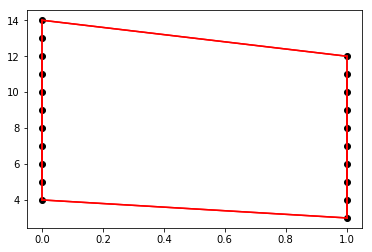

In [19]:
h[0].plot_dual_sub(color='red',name='b')

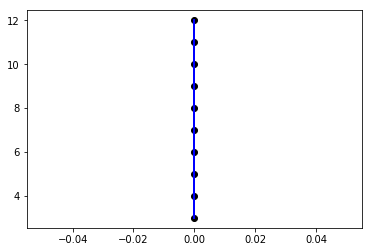

In [20]:
g[0].plot_dual_sub(color='blue',name='b')

In [28]:
h[0] == g[0]*a

True

In [21]:
#я еще доделываю минимизацию на основе polymake

h_min = TropicalPolynomial([[0,1,3],[0,1,12],[0,0,4],[0,0,14]])
g_min = TropicalPolynomial([[0,0,3],[0,0,12]])

In [22]:
h_min

a⨀b^12 ⨁ a⨀b^3 ⨁ b^14 ⨁ b^4

In [23]:
g_min

b^12 ⨁ b^3

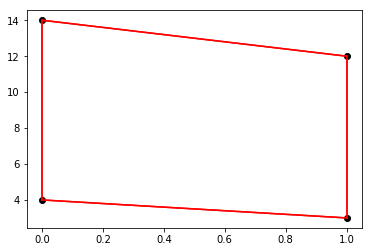

In [26]:
h_min.plot_dual_sub(color='red',name='b')

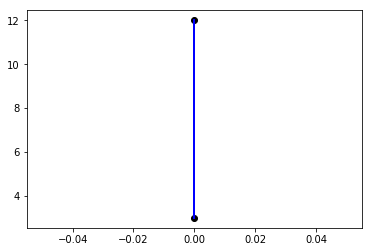

In [27]:
g_min.plot_dual_sub(color='blue',name='b')

In [29]:
#проверим, что полиномы после минимизации численно равны исходным

x_test = [np.random.randint(-2000,2000,size=2) for _ in range(500)]

all(h_min.evaluate(i)==(h[0]).evaluate(i) for i in x_test), all(g_min.evaluate(i)==(g[0]).evaluate(i) for i in x_test)

(True, True)

In [30]:
g_min*a

a⨀b^12 ⨁ b^13 ⨁ a⨀b^3 ⨁ b^14 ⨁ b^4 ⨁ b^5

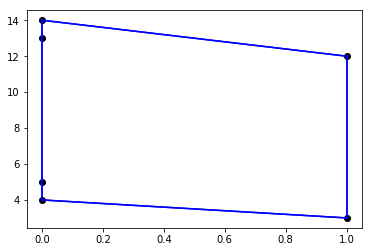

In [95]:
(g_min*a).plot_dual_sub(color='blue',name='b')


In [33]:
h_min

a⨀b^12 ⨁ a⨀b^3 ⨁ b^14 ⨁ b^4

In [34]:
all(h_min.evaluate(i)==(g_min*a).evaluate(i) for i in x_test)

True